## Part 1: Session Data


In [ ]:
# The pakages I need:

# !pip install pyLDAvis -qq
# !pip install -qq -U gensim
# !pip install spacy -qq
# !pip install matplotlib -qq
# !pip install seaborn -qq
# !python -m spacy download en_core_web_md -qq

In [9]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_json('schedule.json')
data

,schedule
base_url,https://pretalx.com/pyconde-pydata-berlin-2023...
conference,"{'acronym': 'pyconde-pydata-berlin-2023', 'tit..."
version,1.3


In [4]:
# Create a new dataframe with columns day, room, id, title, absract
df = pd.DataFrame(columns = ['day', 'room', 'id', 'title', 'track', 'abstract'])
df

,day,room,id,title,track,abstract


In [5]:
# Interate over the 3 days
for i in range(3):
    temp_df = {}
    # Get day
    temp_df['day'] = i
    day = data['schedule'].conference['days'][i]['rooms']
    # Get rooms
    rooms = ['Kuppelsaal', 'B09', 'B07-B08', 'B05-B06', 'A1', 'A03-A04', 'A05-A06']
    # Get sessions of each room
    for room in rooms:
        temp_df['room'] = room
        number_sessions_room = len(day[room])
        
        for session in range(number_sessions_room):
            temp_df['id'] = day[room][session]['id']
            temp_df['title'] = day[room][session]['title']
            temp_df['track'] = day[room][session]['track']
            temp_df['abstract'] = day[room][session]['abstract']
            
            temp = pd.DataFrame([temp_df])
            df = pd.concat([df,temp], ignore_index=True)

In [6]:
df

,day,room,id,title,track,abstract
0,0,Kuppelsaal,26497,Pandas 2.0 and beyond,PyData: PyData & Scientific Libraries Stack,Pandas has reached a 2.0 milestone in 2023. Bu...
1,0,Kuppelsaal,25390,An unbiased evaluation of environment manageme...,PyCon: Programming & Software Engineering,Python packaging is quickly evolving and new t...
2,0,Kuppelsaal,28265,Keynote - A journey through 4 industries with ...,Plenary,"In this keynote, I will share the lessons lear..."
3,0,Kuppelsaal,26247,"Raised by Pandas, striving for more: An opinio...",PyData: Data Handling,Pandas is the de-facto standard for data manip...
4,0,Kuppelsaal,25254,Polars - make the switch to lightning-fast dat...,PyData: Data Handling,"In this talk, we will report on our experience..."
...,...,...,...,...,...,...
110,2,A03-A04,25857,Most of you don't need Spark. Large-scale data...,PyData: Data Handling,The Python data ecosystem has matured during t...
111,2,A03-A04,30171,Contributing to an open-source content library...,PyData: Natural Language Processing,Bricks is an open-source content library for n...
112,2,A05-A06,26268,Building Hexagonal Python Services,PyCon: Programming & Software Engineering,The importance of enterprise architecture patt...
113,2,A05-A06,26277,Workshop on Privilege and Ethics in Data,General: Ethics & Privacy,Data-driven products are becoming more and mor...


In [7]:
# tracks and their frequency
df.track.value_counts()

track
PyData: Natural Language Processing                                15
PyCon: Programming & Software Engineering                          15
Sponsor                                                            12
PyData: PyData & Scientific Libraries Stack                        10
PyData: Machine Learning & Stats                                   10
PyData: Data Handling                                               9
PyCon: DevOps & MLOps                                               8
PyCon: Python Language                                              4
Plenary                                                             4
PyData: Deep Learning                                               4
General: Ethics & Privacy                                           3
PyCon: Libraries                                                    3
PyData: Jupyter                                                     3
PyCon: Testing                                                      3
General: Other

In [8]:
df.track.nunique()

22

## Part 2: Topic Modeling

<div>
<img src="pipeline.svg" width="700"/>
</div>

In [26]:
# Create a spaCy object, en_core_web_md is spaCy's pre-trained model, as shown in image above 'nlp'
nlp = en_core_web_md.load()

### Data

In [14]:
# Name Entity Recognition
# Call nlp on an abstract, the text will run through a processing pipeline, as shown in image above.
doc = nlp(df.abstract[0])
spacy.displacy.render(doc, style='ent', jupyter=True)

In [31]:
# Remove the tags I don't want
# from spacy.glossary import GLOSSARY 
# lookup_dict = GLOSSARY
# lookup_dict.keys()
remove_tags = ['ADV','ADP','CCONJ','DET','PRON','PUNCT','PART','NUM','SPACE','SYM']

In [32]:
tokens = []
for abstract in nlp.pipe(df.abstract):
    # tokenizer, remove unwanted tags, stopwords, lemmatization
    abstract_token = [token.lemma_ for token in abstract if token.pos_ not in remove_tags and not token.is_stop and token.is_alpha] 
    tokens.append(abstract_token)

In [33]:
tokens[0]

['panda',
 'reach',
 'milestone',
 'mean',
 'come',
 'talk',
 'overview',
 'happen',
 'late',
 'release',
 'panda',
 'highlight',
 'topic',
 'major',
 'new',
 'feature',
 'panda',
 'project',
 'work']

In [34]:
# Create a new column named 'tokens'
df['tokens'] = tokens
df

,day,room,id,title,track,abstract,tokens
0,0,Kuppelsaal,26497,Pandas 2.0 and beyond,PyData: PyData & Scientific Libraries Stack,Pandas has reached a 2.0 milestone in 2023. Bu...,"[panda, reach, milestone, mean, come, talk, ov..."
1,0,Kuppelsaal,25390,An unbiased evaluation of environment manageme...,PyCon: Programming & Software Engineering,Python packaging is quickly evolving and new t...,"[Python, packaging, evolve, new, tool, pop, re..."
2,0,Kuppelsaal,28265,Keynote - A journey through 4 industries with ...,Plenary,"In this keynote, I will share the lessons lear...","[keynote, share, lesson, learn, Python, indust..."
3,0,Kuppelsaal,26247,"Raised by Pandas, striving for more: An opinio...",PyData: Data Handling,Pandas is the de-facto standard for data manip...,"[panda, de, facto, standard, data, manipulatio..."
4,0,Kuppelsaal,25254,Polars - make the switch to lightning-fast dat...,PyData: Data Handling,"In this talk, we will report on our experience...","[talk, report, experience, switch, Pandas, Pol..."
...,...,...,...,...,...,...,...
110,2,A03-A04,25857,Most of you don't need Spark. Large-scale data...,PyData: Data Handling,The Python data ecosystem has matured during t...,"[Python, data, ecosystem, mature, decade, reas..."
111,2,A03-A04,30171,Contributing to an open-source content library...,PyData: Natural Language Processing,Bricks is an open-source content library for n...,"[brick, open, source, content, library, natura..."
112,2,A05-A06,26268,Building Hexagonal Python Services,PyCon: Programming & Software Engineering,The importance of enterprise architecture patt...,"[importance, enterprise, architecture, pattern..."
113,2,A05-A06,26277,Workshop on Privilege and Ethics in Data,General: Ethics & Privacy,Data-driven products are becoming more and mor...,"[data, drive, product, ubiquitous, human, buil..."


In [35]:
# Inputs of LDA: Dictionary- unique id for each token
dictionary = Dictionary(df['tokens'])
print(dictionary)

Dictionary<1822 unique tokens: ['come', 'feature', 'happen', 'highlight', 'late']...>


In [39]:
print(dictionary.token2id)

{'come': 0, 'feature': 1, 'happen': 2, 'highlight': 3, 'late': 4, 'major': 5, 'mean': 6, 'milestone': 7, 'new': 8, 'overview': 9, 'panda': 10, 'project': 11, 'reach': 12, 'release': 13, 'talk': 14, 'topic': 15, 'work': 16, 'Python': 17, 'available': 18, 'basis': 19, 'compare': 20, 'environment': 21, 'evolve': 22, 'exist': 23, 'jungle': 24, 'light': 25, 'lot': 26, 'management': 27, 'packaging': 28, 'pop': 29, 'post': 30, 'predefine': 31, 'regular': 32, 'shed': 33, 'structured': 34, 'tool': 35, 'unbiased': 36, 'Game': 37, 'Quill': 38, 'Studios': 39, 'application': 40, 'build': 41, 'company': 42, 'data': 43, 'day': 44, 'develop': 45, 'engineer': 46, 'game': 47, 'gaming': 48, 'hope': 49, 'industry': 50, 'inspiration': 51, 'interesting': 52, 'keynote': 53, 'learn': 54, 'learning': 55, 'lesson': 56, 'machine': 57, 'pleasure': 58, 'problem': 59, 'scientist': 60, 'share': 61, 'solve': 62, 'type': 63, 'use': 64, 'versatility': 65, 'Apache': 66, 'Arrow': 67, 'Pandas': 68, 'Polars': 69, 'Rust': 7

In [40]:
# Filter out low and high frequency tokens, and limit the vocabulary to a max of 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [44]:
# Build Bag of Word, use function doc2bow() to count the frequency of each word,
# format = list of `(token_id, token_count)` tuples.
BoW = [dictionary.doc2bow(abstract) for abstract in df['tokens']]
BoW[:3]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1)],
 [(1, 1), (3, 1), (4, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3)],
 [(9, 3),
  (13, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 2),
  (19, 1),
  (20, 2),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2)]]

### Build Model

In [48]:
# lda_model = LdaMulticore(corpus=BoW, id2word=dictionary, iterations=50,
#                         num_topics=10, workers=4, passes=10)

Get the optimal number of topics<br>
Metric - coherence score: the degree of semantic similarity between high scoring words in each topic

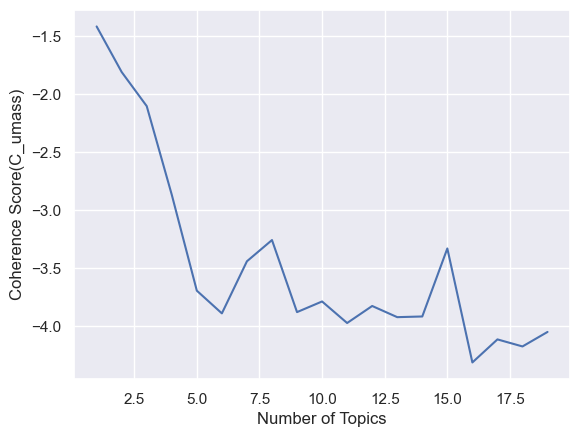

In [49]:
# Iterate different number of topics and save the score in the lists
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=BoW, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=BoW, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score(C_umass)')
plt.show()

In [ ]:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=BoW, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=BoW, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

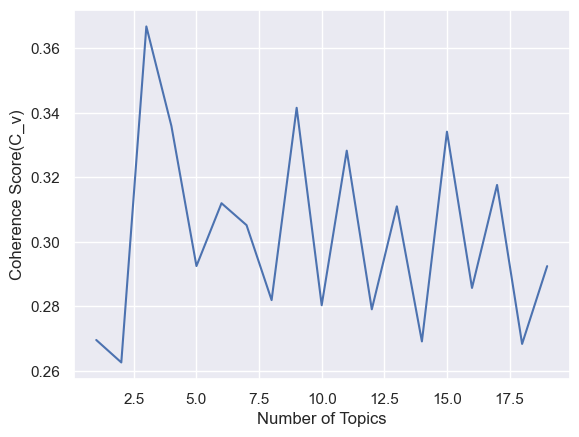

In [58]:
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score(C_v)')
plt.savefig('Coherence_Score.png')
plt.show()

In [60]:
# Choose the number 3 with the highest coherence score 
lda_model = LdaMulticore(corpus=BoW, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100)

In [61]:
lda_model.print_topics(-1)

[(0,
  '0.088*"model" + 0.044*"machine" + 0.039*"datum" + 0.033*"learning" + 0.033*"learn" + 0.025*"ML" + 0.017*"production" + 0.015*"challenge" + 0.012*"tool" + 0.011*"scale"'),
 (1,
  '0.055*"datum" + 0.029*"Python" + 0.029*"use" + 0.023*"source" + 0.023*"open" + 0.021*"new" + 0.019*"tool" + 0.017*"library" + 0.016*"work" + 0.014*"data"'),
 (2,
  '0.036*"Python" + 0.033*"performance" + 0.033*"code" + 0.028*"application" + 0.019*"use" + 0.019*"task" + 0.018*"time" + 0.016*"write" + 0.015*"learn" + 0.014*"build"')]

In [62]:
df['abstract'][0]

'Pandas has reached a 2.0 milestone in 2023. But what does that mean? And what is coming after 2.0? This talk will give an overview of what happened in the latest releases of pandas and highlight some topics and major new features the pandas project is working on.'

In [63]:
lda_model[BoW][0]

[(0, 0.028464478), (1, 0.9422636), (2, 0.029271865)]

In [64]:
# Visualize 
lda_display = pyLDAvis.gensim_models.prepare(lda_model, BoW, dictionary)
pyLDAvis.display(lda_display)

In [65]:
df['topic'] = [sorted(lda_model[BoW][abstract])[0][0] for abstract in range(len(df['abstract']))]

In [66]:
df.topic.value_counts()

topic
0    108
1      6
2      1
Name: count, dtype: int64